## Imports and Dependencies

In [ ]:
try:
    import helical
except:
    !pip install git+https://github.com/helicalAI/helical.git |tail -n 1
    !pip install numpy==1.23.5
    import helical

In [3]:
!pip install numpy==1.23.5

In [339]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import os
import requests
import numpy as np
import scanpy as sc
import torch
import anndata as ad
from anndata import AnnData
from typing import List
import pandas as pd

from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.base_models import HelicalRNAModel

In [2]:
def download_files(files: list[str])-> None:

    for filename in files:
        url = f"https://helicalpackage.blob.core.windows.net/helicalpackage/data/{filename}"

        # Check if the file already exists in the current directory
        if os.path.exists(filename):
            print(f"Files already exist. Skipping downloads.")
        else:
            response = requests.get(url)
            if response.status_code == 200:
                with open(filename, "wb") as file:
                    file.write(response.content)
                print(f"Downloaded {filename} successfully.")
            else:
                print(f"Failed to download {filename}.")

In [3]:
files = ["c_data.h5ad", "ms_default.h5ad", "10k_pbmcs_proc.h5ad"]
download_files(files)

Downloaded c_data.h5ad successfully.
Downloaded ms_default.h5ad successfully.
Downloaded 10k_pbmcs_proc.h5ad successfully.


In [206]:
import warnings
warnings.simplefilter("ignore", ResourceWarning)
warnings.simplefilter("ignore", ImportWarning)
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)


## Function to Perturb Genes

To knockout genes we set their expression levels in the count matrix as 0

In [334]:
def knockout_genes(
    adata: AnnData,
    model: HelicalRNAModel,
    gene_names_column: str,
    genes_to_knockout: List[str],
    gene_names_in_var_index: bool= False,
    ):

    """
    Knock out specified genes from single-cell RNA-seq data and obtain embeddings from a given model.

    This function modifies the input AnnData object by setting the expression levels of specified genes to zero,
    processes the original and modified data using a provided model, and returns their embeddings.

    Args:
        adata (AnnData): The AnnData object containing single-cell RNA-seq data. This object should have gene names in the
                         `var_names` or a specified column of `adata.var` if `gene_names_in_var_index` is `False`.
        model (HelicalRNAModel): A model object with methods `process_data` and `get_embeddings` to process data and
                                 obtain embeddings, respectively.
        gene_names_column (str): The column name in `adata.var` that contains gene names if `gene_names_in_var_index`
                                 is `False`. If `gene_names_in_var_index` is `True`, this argument is ignored.
        genes_to_knockout (List[str]): A list of gene names to be knocked out (i.e., set expression to zero) in the data.
        gene_names_in_var_index (bool, optional): If `True`, the gene names are assumed to be in the index of `adata.var`.
                                                  If `False`, gene names are in the specified `gene_names_column`.
                                                  Defaults to `False`.

    Returns:
        Tuple: A tuple containing:
            - original_embeddings: The embeddings obtained from the original data after processing with the model.
            - ko_embeddings: The embeddings obtained from the data with the specified genes knocked out after processing
                              with the model.

    Raises:
        ValueError: If none of the specified genes to knock out are found in the AnnData object.
    """

    # Using Cuda if available
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Checking the validaity of the specified genes to knockout
    if not gene_names_in_var_index:
      adata.var_names = adata.var[gene_names_column].astype(str)

    genes_to_knockout = [gene for gene in genes_to_knockout if gene in adata.var_names]

    if not genes_to_knockout:
      raise ValueError('Genes specified for knockout not found in data')

    # Knocing out data
    knockout_data = adata.copy()

    # Convert the matrix to lil_matrix for efficient modification
    knockout_data.X = knockout_data.X.tolil()

    # Knockout specified genes (set expression to 0)
    for gene in genes_to_knockout:
        gene_index = knockout_data.var_names.get_loc(gene)
        knockout_data[:, gene_index].X = 0

    # Convert the matrix back to csr_matrix
    knockout_data.X = knockout_data.X.tocsr()

    # Processing and Tokenizing the data
    processed_data = model.process_data(adata=adata,
                                        gene_names = gene_names_column)

    processed_ko_data = model.process_data(adata = knockout_data,
                                            gene_names = gene_names_column)

    original_embeddings = model.get_embeddings(processed_data)
    ko_embeddings = model.get_embeddings(processed_ko_data)

    return original_embeddings, ko_embeddings


Sample Data File

In [336]:
## Loading AnnData File
filepath = '10k_pbmcs_proc.h5ad'
adata = sc.read(filepath)

# Taking subset of the cells to expedite computation
adata = adata[:100]

print(f'{filepath} subset contains {adata.n_obs} cells and {adata.n_vars} genes')

10k_pbmcs_proc.h5ad subset contains 100 cells and 12000 genes


In [337]:
## Loding Model
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=10, device=device)
scgpt = scGPT(configurer = scgpt_config)

In [58]:
## Visualizing var matrix
adata.var

,gene_symbols,n_counts-0,n_counts-1,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm
SAMD11,SAMD11,7.0,4.0,11.0,True,8398.0,0.000917,0.000917,0.937632
PLEKHN1,PLEKHN1,30.0,10.0,39.0,True,7424.0,0.003253,0.003409,0.945401
HES4,HES4,580.0,294.0,855.0,True,189.0,0.071309,0.200353,2.573027
ISG15,ISG15,4014.0,1888.0,5705.0,True,269.0,0.475813,1.413837,2.089724
AGRN,AGRN,36.0,8.0,41.0,True,7906.0,0.003420,0.003575,0.941332
...,...,...,...,...,...,...,...,...,...
MT-ATP8,MT-ATP8,520.0,344.0,836.0,True,5234.0,0.069725,0.073376,0.964173
MT-ATP6,MT-ATP6,78550.0,39285.0,113979.0,True,11712.0,9.506172,51.530156,0.903539
MT-CO3,MT-CO3,180752.0,93005.0,264492.0,True,1143.0,22.059383,256.237361,1.195891
MT-ND4,MT-ND4,116821.0,58847.0,169921.0,True,2444.0,14.171893,109.017994,1.023638


In [341]:
## Speciying genes to knockout, here we choose 1000 genes of the higest n_count to see the effect
gene_pd = pd.DataFrame(adata.var)
genes_to_knockout = gene_pd.sort_values(by='n_counts').tail(1000).index.to_list()

In [188]:
orig_embeddings, pert_embeddings = knockout_genes(adata, model = scgpt,
               gene_names_column='gene_symbols',
               genes_to_knockout=genes_to_knockout,
               gene_names_in_var_index=True)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

Embedding cells: 100%|██████████| 10/10 [02:39<00:00, 15.94s/it]


## Embeddings Visualization


In [512]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.patches import Patch
import umap
import plotly.graph_objects as go


### Similarity Score Function

In [487]:
def calc_similarity(original_embedding: np.ndarray,
                    perturbed_embedding: np.ndarray) -> np.ndarray:
    """
    Calculates cosine similarity between corresponding rows of two 2D arrays

    Args:
      original_embedding (np.ndarray): 2D Array representing the embeddings of the cells before knockout of shape (#cells, embedding_dim)
      perturbed_embedding (np.ndarray): 2D Array representing the embeddings of the cells after knockout of shape (#cells, embedding_dim)

    Returns:
      np.ndarray: 1D array containing the cosine smilarity score of shape (#cells,)

    Raises:
      ValueError: If number of cells in original_embedding and perturbed_embedding
    """
    # Ensure original_embedding and perturbed_embedding are numpy arrays
    original_embedding = np.array(original_embedding)
    perturbed_embedding = np.array(perturbed_embedding)

    # Check if the two embeddings have the same number of cells
    if original_embedding.shape[0] != perturbed_embedding.shape[0]:
        raise ValueError("The number of cells in original_embedding and perturbed_embedding must be the same.")

    # Calculate cosine similarity for each pair of embeddings
    cosine_similarity_array = [cosine_similarity(
        original_embedding[i].reshape(1, -1),
        perturbed_embedding[i].reshape(1, -1)
    )[0, 0] for i in range(original_embedding.shape[0])]

    return np.array(cosine_similarity_array)

### Sample Implementation

In [191]:
cos_sim_array = calc_similarity(orig_embeddings, pert_embeddings)

In [192]:
cos_sim_array

array([0.850726  , 0.77028656, 0.8228433 , 0.82680774, 0.76074517,
       0.8083859 , 0.8640058 , 0.826152  , 0.8924425 , 0.7986057 ,
       0.8432077 , 0.8688827 , 0.8314248 , 0.87653613, 0.7664137 ,
       0.885625  , 0.80842435, 0.8938533 , 0.88899106, 0.8780714 ,
       0.8747717 , 0.78886664, 0.83185685, 0.7716262 , 0.8153832 ,
       0.8287381 , 0.83660287, 0.8718639 , 0.89887846, 0.8475715 ,
       0.8469335 , 0.81426084, 0.81749946, 0.86853975, 0.8751495 ,
       0.8717348 , 0.90870017, 0.86878264, 0.88083625, 0.83158195,
       0.8202013 , 0.86535525, 0.8679686 , 0.91066694, 0.7908738 ,
       0.78473514, 0.89446396, 0.83499706, 0.81450117, 0.8513371 ,
       0.8539785 , 0.8641154 , 0.8270722 , 0.7889521 , 0.89349484,
       0.89423984, 0.8091745 , 0.8568681 , 0.9000869 , 0.9274386 ,
       0.8608966 , 0.8907639 , 0.8860735 , 0.88325167, 0.8462928 ,
       0.86178356, 0.92664206, 0.79374975, 0.8608972 , 0.8486425 ,
       0.8061492 , 0.9154412 , 0.83230764, 0.8906494 , 0.72794

### Visualization Functions

In [537]:
def plot_similarity(similarity_array:np.ndarray,
                    similarity_scoring_method: str ='cosine_similarity',
                    plot_type='violin'):
  """
  Plots the distribution of similarity scores using either a violin or box plot.

  This function takes an array of similarity scores, converts it into a DataFrame, and generates a plot based on
  the specified `plot_type`. The plot visualizes the distribution of similarity scores using either a violin plot
  or a box plot, and includes all data points.

  Args:
      similarity_array (np.ndarray): A 1D array or a 2D array where each row represents similarity scores.
                                      If 2D, the plot will use the first column.
      similarity_scoring_method (str, optional): The name of the similarity scoring method, which will be used as
                                                  the label in the plot. Defaults to 'cosine_similarity'.
      plot_type (str, optional): The type of plot to generate. Options are 'violin' or 'box'. Defaults to 'violin'.

  Returns:
      A figure object representing the generated plot.

  Raises:
      ValueError: If `plot_type` is not one of 'violin' or 'box'.
  """
  similarity_df = pd.DataFrame(similarity_array, columns=[similarity_scoring_method])
  plt.figure(figsize=(10, 6))

  if plot_type == 'violin':
      sns.violinplot(data=similarity_df, x=similarity_scoring_method, inner='quartile')
      plt.title(f"Violin plot for {similarity_scoring_method} scores")
  elif plot_type == 'box':
      sns.boxplot(data=similarity_df, x=similarity_scoring_method)
      plt.title(f"Box plot for {similarity_scoring_method} scores")
  else:
      raise ValueError('Plot type not supported. Please use "violin" or "box".')
  plt.show()
  return plt.gcf()

In [568]:
  def plot_embeddings_heatmaps(original_embeddings: np.ndarray,
                             perturbed_embeddings: np.ndarray):
    """
    Plots heatmaps of the embeddings for original and perturbed data, with clustering of rows and columns.
    The heatmap uses hierarchical clustering to group similar rows and columns

    Args:
      original_embeddings (np.ndarray): 2D Array representing the embeddings of the cells
                                        before knockout of shape (#cells, embedding_dim)
      perturbed_embeddings (np.ndarray): 2D Array representing the embeddings of the cells
                                         after knockout of shape (#cells, embedding_dim)


    Returns:
        plt: The matplotlib `plt` object for the generated heatmap.
    """
    # Normalize embeddings to be in the same range
    original_embeddings_normalized = original_embeddings / np.max(np.abs(original_embeddings), axis=0)
    perturbed_embeddings_normalized = perturbed_embeddings / np.max(np.abs(perturbed_embeddings), axis=0)

    # Concatenate normalized embeddings
    all_embeddings = np.concatenate((original_embeddings_normalized, perturbed_embeddings_normalized))
    labels = ['original' for _ in range(original_embeddings.shape[0])] + ['perturbed' for _ in range(perturbed_embeddings.shape[0])]
    df = pd.DataFrame(all_embeddings)
    df['label'] = labels

    # Compute linkage for clustering
    row_linkage = linkage(all_embeddings, method='single')
    col_linkage = linkage(all_embeddings.T, method='single')

    # Colormap
    cmap = sns.color_palette("vlag", as_cmap=True)

    # Label Colors
    label_colors = {'original': 'brown', 'perturbed': 'green' }
    row_colors = df['label'].map(label_colors)

    g = sns.clustermap(df.drop(columns=['label']),
                       row_cluster=True, col_cluster=True,
                       row_linkage=row_linkage, col_linkage=col_linkage,
                       cmap=cmap, figsize=(12, 8),
                       row_colors=row_colors)

    g.ax_heatmap.set_xticks([])
    g.ax_heatmap.set_yticks([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.set_yticklabels([])

    g.ax_heatmap.set_ylabel(f'Number of Cells {original_embeddings.shape[0]}')
    g.ax_heatmap.set_xlabel(f'Embedding Dimension {original_embeddings.shape[1]}')

    legend_elements = [Patch(facecolor='brown', label='Original'),
                       Patch(facecolor='green', label='Perturbed')]

    g.ax_heatmap.legend(handles=legend_elements, loc='upper right', title='Labels')

    return g

In [569]:
def plot_umap(original_embeddings, perturbed_embeddings):
  """
  Plots UMAP visualization of the original and perturbed embeddings.

  This function applies Uniform Manifold Approximation and Projection (UMAP) to the concatenated embeddings
  of original and perturbed data, and generates a scatter plot showing the UMAP representation.

  Args:
    original_embeddings (np.ndarray): 2D Array representing the embeddings of the cells
                                      before knockout of shape (#cells, embedding_dim)
    perturbed_embeddings (np.ndarray): 2D Array representing the embeddings of the cells
                                        after knockout of shape (#cells, embedding_dim)


  Returns:
      A figure object representing the generated plot.
  """
  reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None, n_neighbors=100)

  all_embeddings = np.concatenate((original_embeddings, perturbed_embeddings))
  mapper = reducer.fit(all_embeddings)

  df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
  labels = ['original' for _ in range(original_embeddings.shape[0])] + ['perturbed' for _ in range(perturbed_embeddings.shape[0])]
  df['label'] = labels

  plt.figure(figsize=(10, 6))
  sns.scatterplot(data=df, x='px', y='py', hue='label',
                  palette=['#636EFA', '#EF553B'])
  plt.title('UMAP Plot')
  plt.legend(title='Condition')
  plt.show()
  return plt


### Sample Implementation

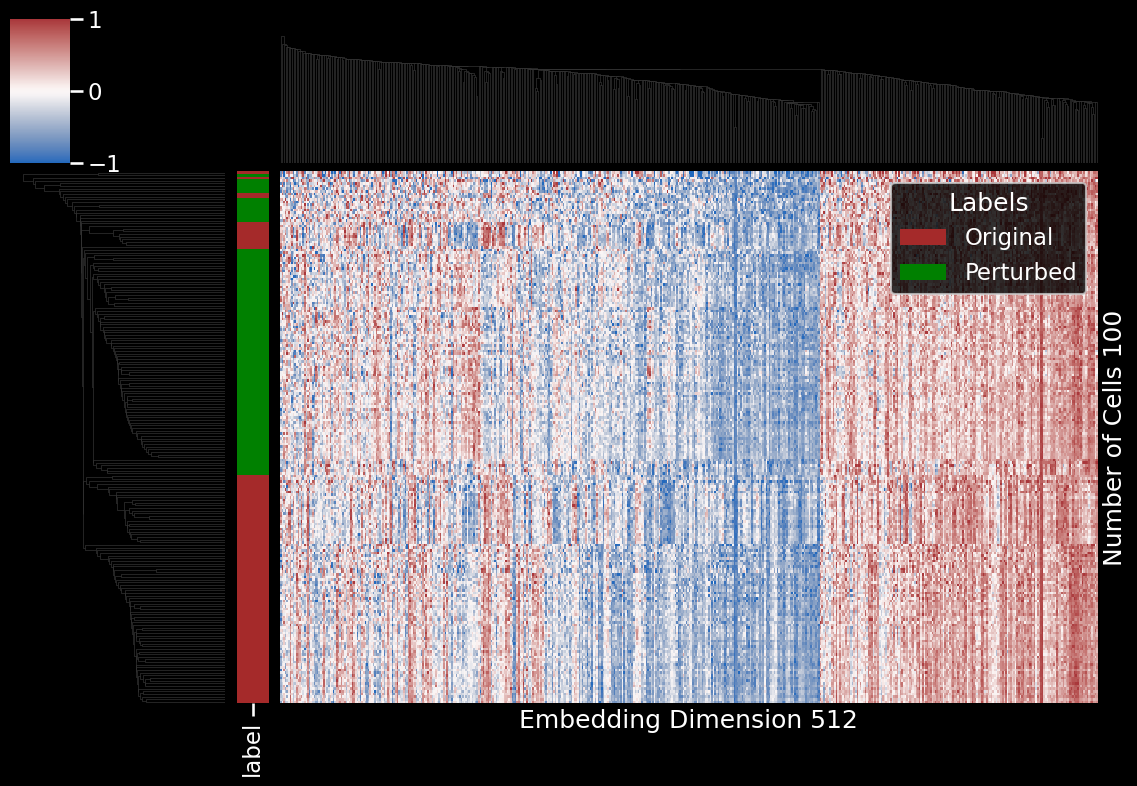

In [570]:
plot_embeddings_heatmaps(orig_embeddings, pert_embeddings)

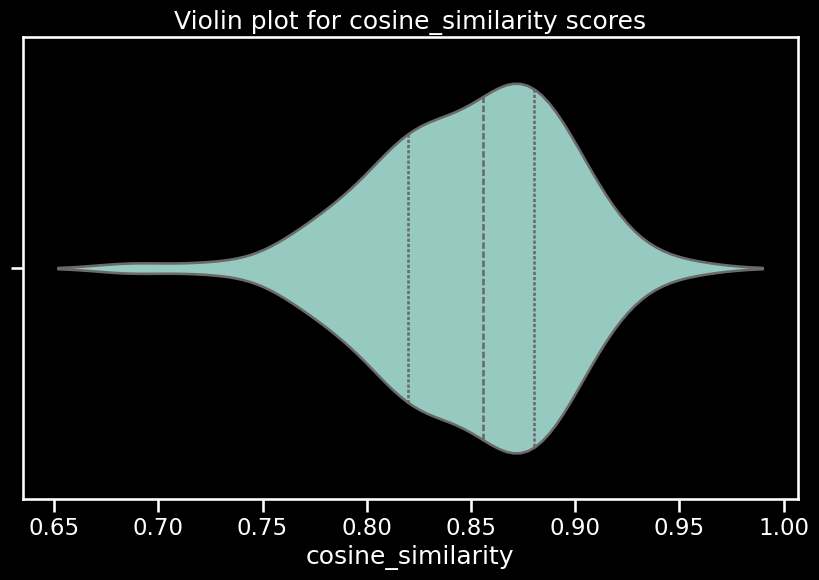

<Figure size 640x480 with 0 Axes>

In [531]:
fig = plot_similarity(cos_sim_array, plot_type='violin')

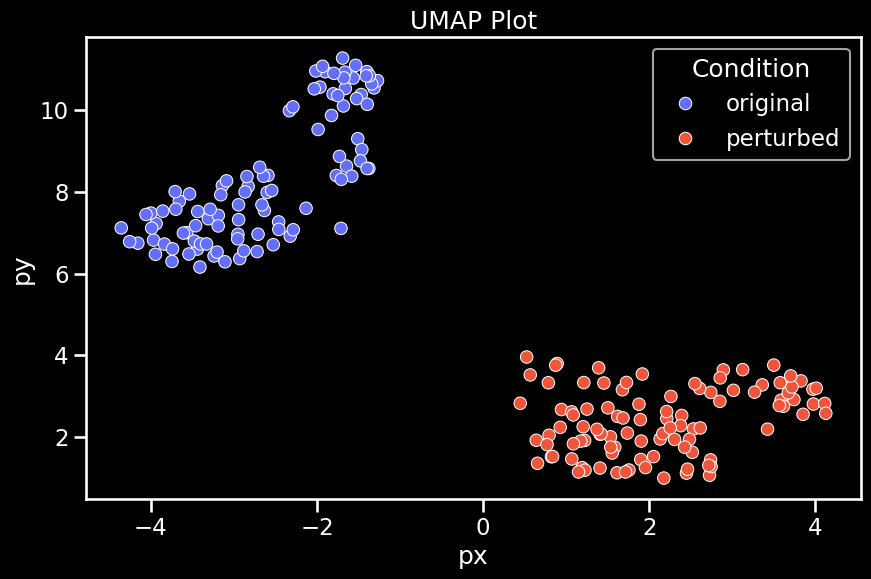

In [544]:
fig= plot_umap(orig_embeddings, pert_embeddings)

## Classifier

In [383]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             recall_score,
                             f1_score,
                             precision_score,
                             roc_auc_score)

Simple Pytorch Neural Network

In [469]:
# Model
class NNClassifier(nn.Module):
    def __init__(self, embedding_dim):
        super(NNClassifier, self).__init__()
        self.classifier_head = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid())
        self.criterion = nn.BCELoss()

    def forward(self, x):
        x = self.classifier_head(x)
        return x.squeeze()


In [470]:
# Model Info
model = NNClassifier(embedding_dim=512)
print(model)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters is: {}".format(params))

NNClassifier(
  (classifier_head): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
  (criterion): BCELoss()
)
Total number of trainable parameters is: 149889


In [471]:
# Datasets assuming data is first provides as pd.DataFrame
class ClassificationDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']
        features = row.drop('label').values.astype(np.float32)

        return torch.tensor(features), torch.tensor(label)


In [472]:
# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device).float()
            outputs = model(x)
            preds = (outputs > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    return precision, recall, f1, auc, all_preds, all_labels

In [473]:
# Training Args
epochs = 3
optimizer = optim.Adam(model.parameters(), lr=0.001)

Sample Implementation

In [474]:
all_embeddings = np.concatenate((orig_embeddings, pert_embeddings))
labels = [0.0 for _ in range(orig_embeddings.shape[0])] + [1.0 for _ in range(pert_embeddings.shape[0])]
df = pd.DataFrame(all_embeddings)
df['label'] = labels

In [475]:
df_train_val, df_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42, stratify=df_train_val['label'])

In [476]:
train_dataset = ClassificationDataset(dataframe=df_train)
val_dataset = ClassificationDataset(dataframe=df_val)
test_dataset = ClassificationDataset(dataframe=df_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [477]:
# Training loop
model = model.to(device=device)  # move the model parameters to CPU/GPU
for e in range(epochs):
    model.train()  # Set model to training mode
    for (x, y) in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device).float()

        scores = model(x)
        loss = model.criterion(scores, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation after each epoch
    print(f'Epoch: {e}, loss = {loss.item():.4f}')
    train_precision, train_recall, train_f1, train_auc, _, _ = evaluate(model, train_loader)
    val_precision, val_recall, val_f1, val_auc, _, _  = evaluate(model, val_loader)

    print(f'Train Precision = {train_precision:.4f}, Train Recall = {train_recall:.4f}, Train F1 = {train_f1:.4f}, Train AUC = {train_auc:.4f}')
    print(f'Val Precision = {val_precision:.4f}, Val Recall = {val_recall:.4f}, Val F1 = {val_f1:.4f}, Val AUC = {val_auc:.4f}')


100%|██████████| 11/11 [00:00<00:00, 47.87it/s]


Epoch: 0, loss = 0.6758
Train Precision = 1.0000, Train Recall = 0.8272, Train F1 = 0.9054, Train AUC = 0.9136
Val Precision = 1.0000, Val Recall = 0.8889, Val F1 = 0.9412, Val AUC = 0.9444



100%|██████████| 11/11 [00:00<00:00, 45.60it/s]


Epoch: 1, loss = 0.6343
Train Precision = 1.0000, Train Recall = 1.0000, Train F1 = 1.0000, Train AUC = 1.0000
Val Precision = 1.0000, Val Recall = 1.0000, Val F1 = 1.0000, Val AUC = 1.0000



100%|██████████| 11/11 [00:00<00:00, 53.64it/s]


Epoch: 2, loss = 0.4947
Train Precision = 0.9878, Train Recall = 1.0000, Train F1 = 0.9939, Train AUC = 0.9938
Val Precision = 1.0000, Val Recall = 1.0000, Val F1 = 1.0000, Val AUC = 1.0000


Test Set Results

In [478]:
test_precision,test_recall,test_F1,test_AUC, preds, labels = evaluate(model, test_loader)
print(f'Precision: {test_precision*100:.2f}%,\
        Recall: {test_recall*100:.2f}%,\
        F1_Score: {test_F1*100:.2f}%,\
        AUC: {test_AUC*100:.2f}%')

Precision: 90.91%,        Recall: 100.00%,        F1_Score: 95.24%,        AUC: 95.00%


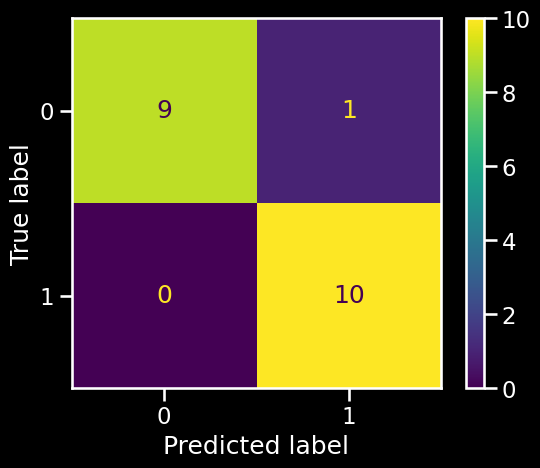

In [479]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cfm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cfm)
disp.plot()

## Knocking Out Genes with High n_counts Versus Random Knocking Out


In [396]:
adata

View of AnnData object with n_obs × n_vars = 100 × 12000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_types', 'hvg'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

In [425]:
gene_pd = pd.DataFrame(adata.var)
genes_to_knockout_rand = gene_pd[:1000].index.to_list()

In [433]:
genes_to_knockout_high = gene_pd.sort_values(by='n_counts').tail(1000).index.to_list()

In [426]:
orig_embeddings_high, pert_embeddings_high = orig_embeddings, pert_embeddings

In [400]:
orig_embeddings_rand, pert_embeddings_rand = knockout_genes(adata, model = scgpt,
               gene_names_column='gene_symbols',
               genes_to_knockout=genes_to_knockout_rand,
               gene_names_in_var_index=True)

/usr/local/lib/python3.10/dist-packages/helical/models/base_models.py:83: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling


Embedding cells: 100%|██████████| 10/10 [04:19<00:00, 25.97s/it]

Embedding cells: 100%|██████████| 10/10 [04:19<00:00, 25.98s/it]


In [402]:
orig_embeddings_high, pert_embeddings_high = knockout_genes(adata, model = scgpt,
               gene_names_column='gene_symbols',
               genes_to_knockout=genes_to_knockout_high,
               gene_names_in_var_index=True)


Embedding cells: 100%|██████████| 10/10 [04:11<00:00, 25.17s/it]

Embedding cells: 100%|██████████| 10/10 [03:49<00:00, 22.99s/it]


In [428]:
similarity_high = calc_similarity(orig_embeddings_high, pert_embeddings_high)

In [430]:
similarity_rand = calc_similarity(orig_embeddings_rand, pert_embeddings_rand)

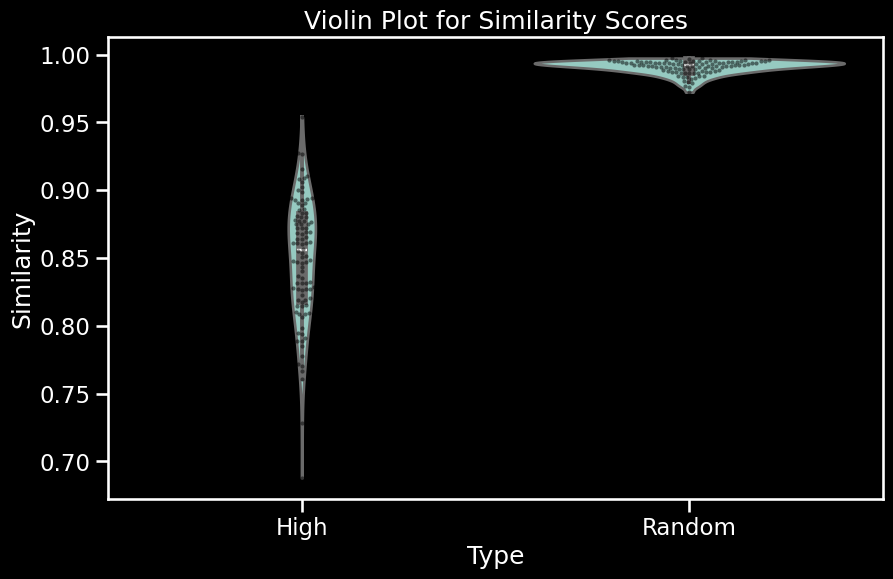

In [563]:
similarity_df = pd.DataFrame({
    'Similarity': np.concatenate((similarity_high,similarity_rand)),
    'Type': ['High' for _ in range(len(similarity_high))] + ['Random' for _ in range(len(similarity_rand))]
})

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=similarity_df, x='Type', y='Similarity', inner='box', cut=0)
sns.swarmplot(data=similarity_df, x='Type', y='Similarity', color='k', alpha=0.5, size=3)

# Add title and labels
plt.title('Violin Plot for Similarity Scores')
plt.xlabel('Type')
plt.ylabel('Similarity')

# Show plot
plt.show()

As expected the similarity scores of knocking out 1000 genes results in lower similarity scores compared to knocking out 100 genes, indicating a higher deletrious effect

Random Knockout heat maps



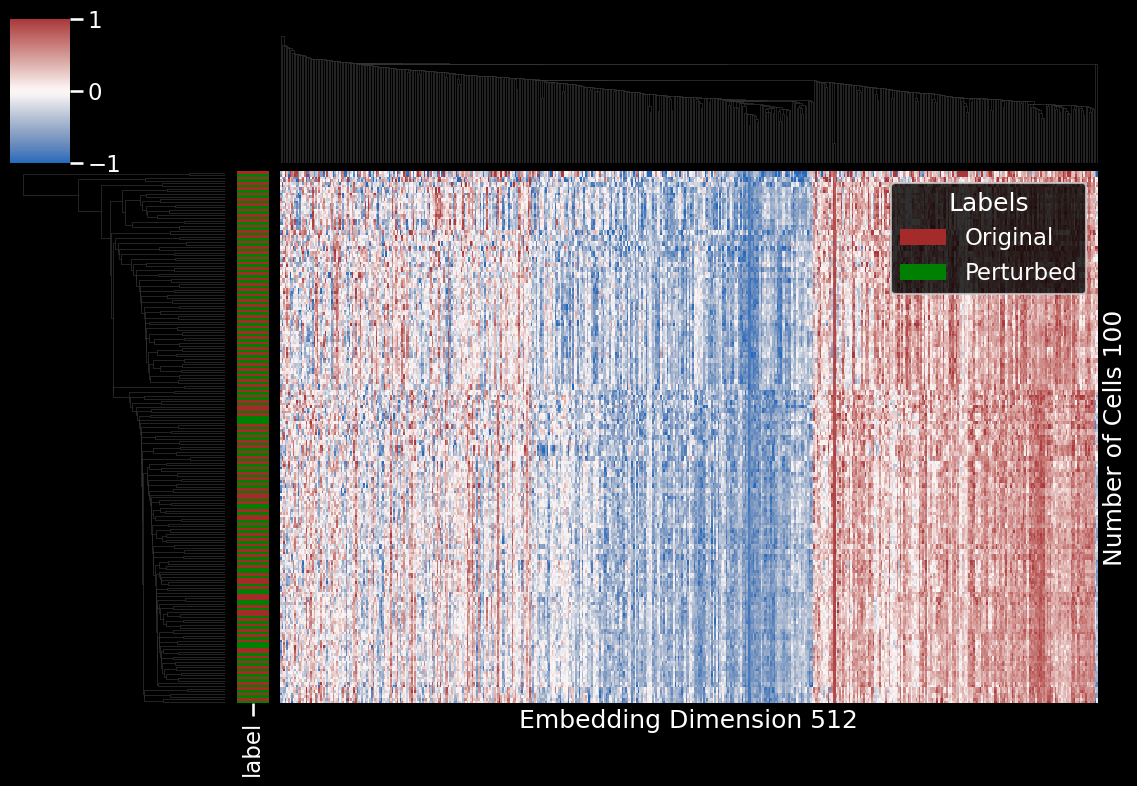

In [552]:
print('Random Knockout heat maps\n')
plt = plot_embeddings_heatmaps(orig_embeddings_rand, pert_embeddings_rand)




High count Knockout heat maps



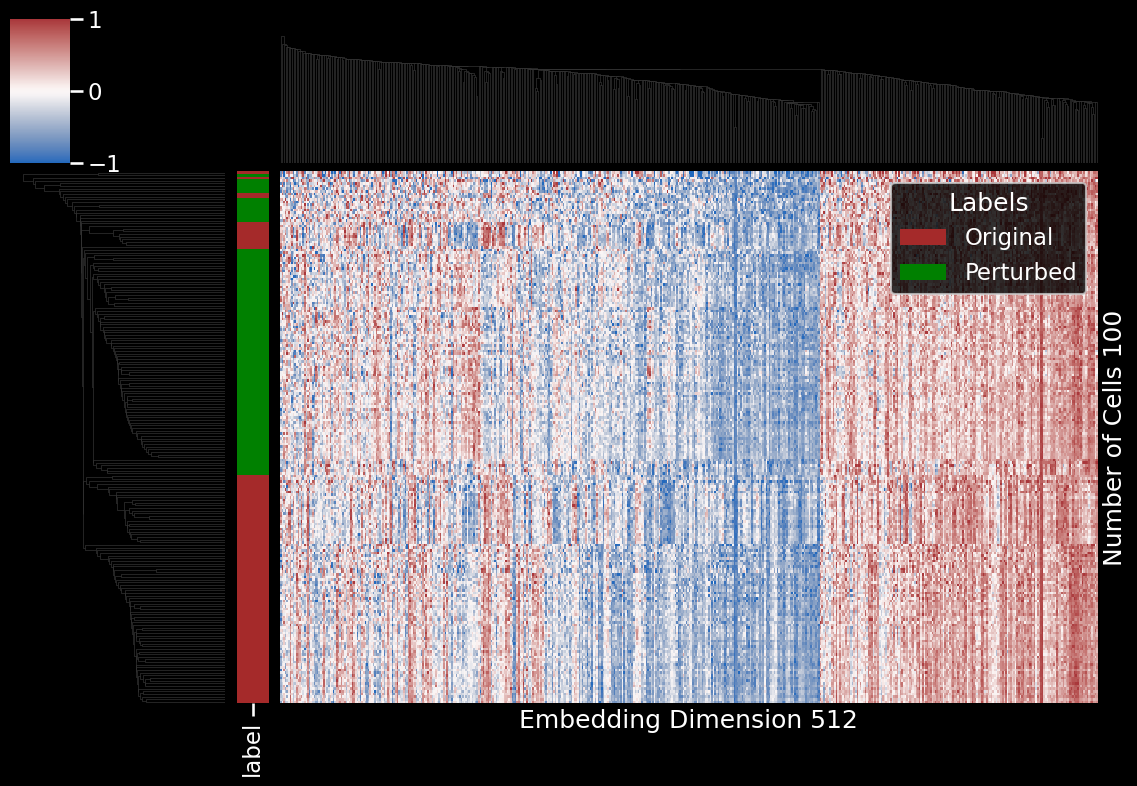

In [553]:
print('\nHigh count Knockout heat maps\n')
plt = plot_embeddings_heatmaps(orig_embeddings_high, pert_embeddings_high)

Random Knockout



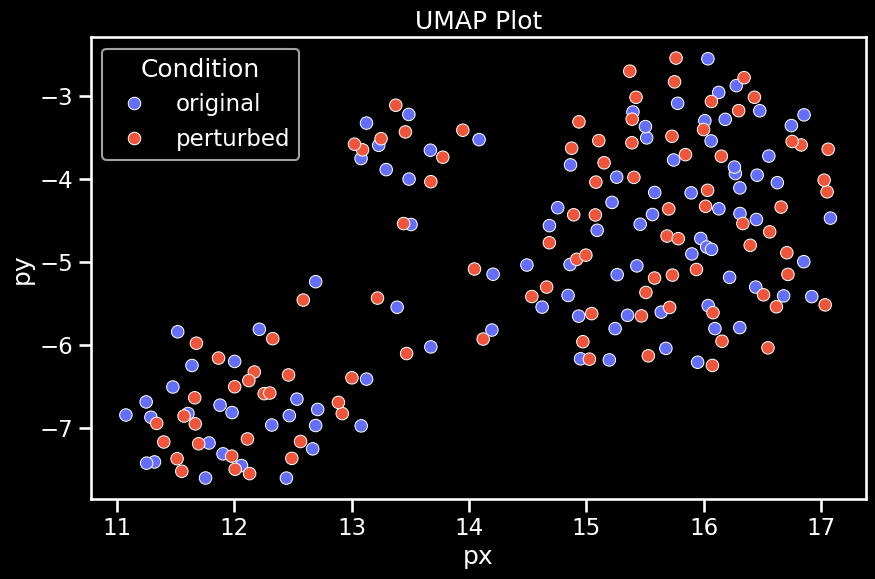


High count Knockout 



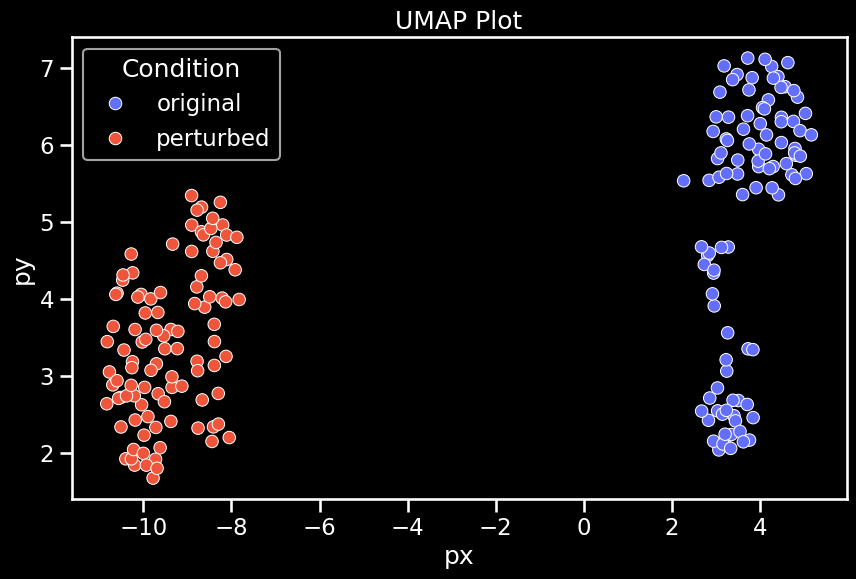

In [554]:
print('Random Knockout\n')
plt = plot_umap(orig_embeddings_rand, pert_embeddings_rand)
plt.show()
print('\nHigh count Knockout \n')
plt = plot_umap(orig_embeddings_high, pert_embeddings_high)
plt.show()

In [436]:
all_embeddings_rand = np.concatenate((orig_embeddings_rand, pert_embeddings_rand))
labels_rand = [0.0 for _ in range(orig_embeddings_rand.shape[0])] + [1.0 for _ in range(pert_embeddings_rand.shape[0])]
df_rand = pd.DataFrame(all_embeddings_rand)
df_rand['label'] = labels_rand

In [437]:
df_train_val_rand, df_test_rand = train_test_split(df_rand, test_size=0.1, random_state=42, stratify=df_rand['label'])
df_train_rand, df_val_rand = train_test_split(df_train_val_rand, test_size=0.1, random_state=42, stratify=df_train_val_rand['label'])

In [438]:
train_dataset_rand = ClassificationDataset(dataframe=df_train_rand)
val_dataset_rand = ClassificationDataset(dataframe=df_val_rand)
test_dataset_rand = ClassificationDataset(dataframe=df_test_rand)

train_loader_rand = DataLoader(train_dataset_rand, batch_size=16, shuffle=True)
val_loader_rand = DataLoader(val_dataset_rand, batch_size=16, shuffle=False)
test_loader_rand = DataLoader(test_dataset_rand, batch_size=16, shuffle=False)

In [449]:
# Training loop
model = model.to(device=device)  # move the model parameters to CPU/GPU
for e in range(epochs):
    model.train()  # Set model to training mode
    for (x, y) in tqdm(train_loader_rand):
        x = x.to(device)
        y = y.to(device).float()

        scores = model(x)
        loss = model.criterion(scores, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation after each epoch
    print(f'Epoch: {e}, loss = {loss.item():.4f}')
    train_precision, train_recall, train_f1, train_auc, _, _ = evaluate(model, train_loader_rand)
    val_precision, val_recall, val_f1, val_auc, _, _  = evaluate(model, val_loader_rand)

    print(f'Train Precision = {train_precision:.4f}, Train Recall = {train_recall:.4f}, Train F1 = {train_f1:.4f}, Train AUC = {train_auc:.4f}')
    print(f'Val Precision = {val_precision:.4f}, Val Recall = {val_recall:.4f}, Val F1 = {val_f1:.4f}, Val AUC = {val_auc:.4f}')


100%|██████████| 11/11 [00:00<00:00, 54.96it/s]


Epoch: 0, loss = 0.5950
Train Precision = 0.5417, Train Recall = 0.1605, Train F1 = 0.2476, Train AUC = 0.5123
Val Precision = 0.3333, Val Recall = 0.1111, Val F1 = 0.1667, Val AUC = 0.4444



100%|██████████| 11/11 [00:00<00:00, 52.70it/s]


Epoch: 1, loss = 0.6829
Train Precision = 0.6118, Train Recall = 0.6420, Train F1 = 0.6265, Train AUC = 0.6173
Val Precision = 0.3750, Val Recall = 0.3333, Val F1 = 0.3529, Val AUC = 0.3889



100%|██████████| 11/11 [00:00<00:00, 46.81it/s]


Epoch: 2, loss = 0.5939
Train Precision = 0.6377, Train Recall = 0.5432, Train F1 = 0.5867, Train AUC = 0.6173
Val Precision = 0.2500, Val Recall = 0.1111, Val F1 = 0.1538, Val AUC = 0.3889


In [453]:
test_precision,test_recall,test_F1,test_AUC, preds, labels = evaluate(model, test_loader_rand)

In [457]:
print(f'Precision: {test_precision*100:.2f}%,\
        Recall: {test_recall*100:.2f}%,\
        F1_Score: {test_F1*100:.2f}%,\
        AUC: {test_AUC*100:.2f}%')

Precision: 40.00%,        Recall: 40.00%,        F1_Score: 40.00%,        AUC: 40.00%


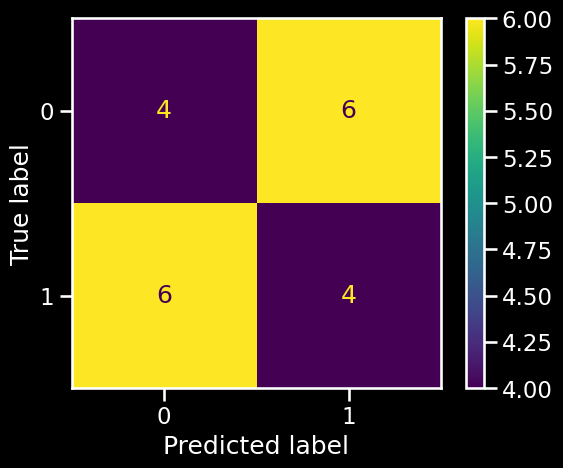

In [451]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cfm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cfm)
disp.plot()

As expected the high counts knockouts had notable effect on the embeddings as distinguished by the similarity vilon plots, heatmaps, and the UMAP plots, these eefects were much less distinguishable with random knockouts. The simple NN classifier also easily distinguished cells with high knockout compared to random knockouts. Sample implentations were run on the high knockout data.

Random Knockout Results:
- Precision: 40.00%     
- Recall: 40.00%      
- F1_Score: 40.00%       
- AUC: 40.00%

High Knockout Results:
- Precision: 90.91%        
- Recall: 100.00%       
- F1_Score: 95.24%,        
- AUC: 95.00%
